In [1]:
using HDF5, EzXML, Glob, Dates, Plots, Optim, LineSearches, LsqFit, JuMP
import NLopt
include("/Users/jjc/CSF/CSF Dynamics Scripts/readCSF.jl")

datapath = "/Users/jjc/Documents/SSC/CSF Data/selected_recordings"
path = pwd();
savepath = "/Users/jjc/CSF/"
files = glob("*.hdf5", datapath);

# filename =  datapath*"/INF_20200909122333_INF2.hdf5"
# filename = datapath*"/INF_20190708150215_INF2.hdf5"
# filename = datapath*"/INF_20191010113919_INF2.hdf5"
filename = datapath * "/INF_9CA2CCEC_E238_4CB0_99DC_78B94C06CAB9.hdf5"
# filename = datapath*"/INF_20190620142837_INF2.hdf5"
# filename = datapath * "/inf_20180329121402.hdf5"
# filename = datapath * "/INF_20180829151805_INF2.hdf5"

Data = readCSF(filename)

T = Data["T"]
rec_dur_s = Data["rec_dur_s"]
start_time = Data["start_time"]
end_time = Data["end_time"]
infusion_start_frame = Data["infusion_start_frame"]
infusion_end_frame = Data["infusion_end_frame"]
plateau_start = Data["plateau_start"]
plateau_end = Data["plateau_end"]

ICP = Data["ICP"]

E = Data["E"]
P_0 = Data["P_0"]
P_p = Data["P_p"]
P_b = Data["P_b"]
I_b = Data["I_b"]
I_inf = Data["I_inf"]
;

In [ ]:
# Functions

# TODO: look into windowed-median


# Model equation
function mfun(X, t)
    I_b = X[1]
    E = X[2]
    P_0 = X[3]
    It = I_b + I_inf
    ΔP = P_b - P_0
    y = It * ΔP / (I_b + (I_inf * exp(-E * It * t))) + P_0
    return y
end

# Sum squared error function
function sqerror(X)
    err = 0.0
    for i = 1:length(Pm)
        tᵢ = (i - 1) / 6
        predᵢ = mfun(X, tᵢ)
        err += (Pm[i] - predᵢ)^2
        # i >= plateau_start ? err+=abs(P_p-predᵢ) : 0
    end

    δΔP = maximum([0.0, X[3] - P_b])
    δlb = delta.(lower .- X)
    δub = delta.(X .- upper)
    δ = C .* vcat(δlb, δub, δΔP) # i = 1,⋯,q
    dist = vcat(lower .- X, X .- upper) # Distances between the constraint and the current value
    h = C_dist .* abs.(dist) # i = q+1,⋯,m
    d = vcat(δ, h)
    penalty = sum(d .^ κ)
    return (err + penalty) / length(Pm) #  1/n ∑(true - model)²
end

# Plotting
function plot_model(I_b, E, P_0, ICP, dsampf)

    println("Estimated parameters:\nIₐ = $I_b [mL/min]\n" * "E = $E [mmHg/mL]\n" * "P₀ = $P_0 [mmHg]\n")

    gg = moving_average(ICP, dsampf)
    g0 = zeros(length(ICP))
    g0 .+= P_b
    g0[Int(dsampf / 2):Int(dsampf / 2)+length(gg)-1] = gg
    g0[Int(dsampf / 2)+length(gg):end] .= P_p

    P_m = zeros(numsamples)
    P_m .+= P_b
    P_model = zeros(numsamples)
    ICPm = zeros(infusion_end_frame - infusion_start_frame)

    for i = infusion_start_frame:infusion_end_frame
        tᵢ = (i - infusion_start_frame) / 6
        It = I_b + I_inf
        ΔP = P_b - P_0
        y = It * ΔP / (I_b + (I_inf * exp(-E * It * tᵢ))) + P_0
        P_model[i] = y
    end

    ICPm = P_model[infusion_start_frame:infusion_end_frame]
    P_m[infusion_start_frame:infusion_end_frame] = ICPm
    P_m[infusion_end_frame+1:end] .= ICPm[end]
    # P_m[infusion_end_frame+1:end] .= P_p

    # plateau_end=numsamples
    vline([infusion_start_frame], background=:transparent, legend=:outertopright, linestyle=:dash, linecolor=:white, alpha=0.5, linewidth=1, label="Start of infusion")
    vline!([infusion_end_frame], background=:transparent, legend=:outertopright, linestyle=:dash, linecolor=:white, alpha=0.5, linewidth=1, label="End of infusion")
    vline!([plateau_start], background=:transparent, legend=:outertopright, linestyle=:dash, linecolor=:mint, alpha=0.5, linewidth=1, label="Start of plateau")
    hline!([P_p], linecolor=:coral2, label="Pₚ", linewidth=0.5, alpha=0.5)
    plot!(g0, linewidth=2, alpha=0.8, linecolor=:violet, label="Moving average") # Plot moving average
    plot!(ICP, linecolor=:cadetblue, linewidth=2, label="Measured", alpha=0.7) # Plot ICP from beginning until end of plateau
    # Plot model prediction from beginning until end of plateau
    plot!(P_m, linecolor=:orange, linewidth=2, linestyle=:dash, xlims=[1, plateau_end], ylims=[minimum(ICP)*0.9,maximum(ICP)*1.1],
        xlabel="Time [min]", ylabel="ICP [mmHg]", xticks=([0:30:plateau_end;], [0:30:plateau_end;] ./ 10),
        label="Model", grid=false)
end

function getres(P)
    global Pm = P
    result = optimize(sqerror, x0, LBFGS())
    min_val = Optim.minimum(result)
    return Pm, result, min_val
end

In [ ]:
X = I_b, E, P_0
x0 = [0.3, 0.2, 4] # Starting point
lower = [0.1, 0.01, -5.0]
upper = [0.6, 1.0, P_b]

# Moving average = smoothed trace
dsampf = 20 # Downsampling factor (no. of frames in a window for calculation of the mean)
gg = moving_average(ICP, dsampf)
g0 = zeros(length(ICP))
g0 .+= P_b
g0[Int(dsampf / 2):Int(dsampf / 2)+length(gg)-1] = gg
g0[Int(dsampf / 2)+length(gg):end] .= P_p

C = 10^1
C_dist = 10^1
κ = 2

Pm, result, min_val = getres(ICP[infusion_start_frame:plateau_start])
Pm, result1, min_val1 = getres(ICP[infusion_start_frame:infusion_end_frame])
# result, min_val = getres(g0[infusion_start_frame:infusion_end_frame])
# result1, min_val1 = getres(g0[infusion_start_frame:plateau_start])

if min_val < min_val1
    I_b, E, P_0 = Optim.minimizer(result)
else
    I_b, E, P_0 = Optim.minimizer(result1)
end

# I_b, E, P_0 = Optim.minimizer(result1)

plot_model(I_b, E, P_0)

In [ ]:
# Pm = Pm_ave
mysolver = NewtonTrustRegion(; initial_delta=1.0,
    delta_hat=100.0,
    eta=0.1,
    rho_lower=0.25,
    rho_upper=0.75)

mysolver = GradientDescent()

x0 = [0.3, 0.2, 0]
C = 10^2
C_dist = 10^2
κ = 1

res = Optim.optimize(sqerror, x0, mysolver)
I_b, E, P_0 = Optim.minimizer(res)
plot_model(I_b, E, P_0)

In [ ]:

# Levenberg-Marquardt algorithm

# p[1] = I_b
# p[2] = E
# p[3] = P_0
# p = [I_b, E, P_0]
nsamps = numsamples

t = T
@. model(t, p) = ((I_inf + p[1]) * (P_b - p[3]) / (p[1] + (I_inf * exp(-p[2] * (I_inf + p[1]) * t)))) + p[3]


p0 = [0.3, 0.2, 15]

st = infusion_start_frame
en = infusion_end_frame

xdata = 0:numsamples-1
# xdata = st:en
xdata *= 1 / 6
ydata = ICP

fit = curve_fit(model, t[st:en], ICP[st:en], p0)


sigma = stderror(fit)
margin_of_error = margin_error(fit, 0.05)
confidence_inter = confidence_interval(fit, 0.05)
I_b, E, P_0 = fit.param

G = zeros(numsamples)
for i = 1:numsamples
    It = I_b + I_inf
    ΔP = P_b - P_0
    y = It * ΔP / (I_b + (I_inf * exp(-E * It * t[i]))) + P_0
    G[i] = y
end

println("Ib = $I_b\n E = $E\n P0 = $P_0")

plot([G[1:en], ICP[1:en], g0[1:en]], background=:transparent, linecolor=[:orange :cadetblue :violet], linestyle=[:dash :solid], linewidth=2,
    xlabel="Time [min]", ylabel="ICP [mmHg]", xticks=([0:30:numsamples;], [0:30:numsamples;] ./ 10), legend=:outertopright)



In [ ]:
# Define gradient
function g!(G, X)
    I_b = X[1]
    E = X[2]
    P_0 = X[3]

    # t = 1/6

    It = I_inf + I_b
    ΔP = P_b - P_0
    Q = I_inf * exp(E * t * It)

    # G[1] = ΔP/(Q+I_b)-(ΔP*It*(1-E*I_inf*t*exp(-E*t*It)))/(Q+I_b)^2
    # G[2] = (It^2*ΔP*t*Q)/(I_b*exp(It*t*E)+I_inf)^2
    # G[3] = 1-It/(Q+I_b)

    G[1] = -(I_inf * (P_b - P_0) * exp(E * (I_b + I_inf)) * (exp(E * (I_b + I_inf)) - E * I_b - E * I_inf - 1)) / (I_b * exp(E * (I_b + I_inf)) + I_inf)^2
    G[2] = (I_inf * (I_inf + I_b)^2 * (P_b - P_0) * exp((I_inf + I_b) * E)) / (I_b * exp((I_inf + I_b) * E) + I_inf)^2
    G[3] = 1 - (I_inf + I_b) / (I_inf * exp(-E * (I_inf + I_b)) + I_b)
end

# Define Hessian
function h!(H, X)
    I_b = X[1]
    E = X[2]
    P_0 = X[3]


    # It = I_inf + I_b # Total rate of CSF volume increase
    # ΔP = P_b - P_0 # Pressure difference between ICP at baseline and reference pressure
    # Q = exp(E*t*It) # For neatness
    # t = 1/6
    # Time-dependent - probably should use without time
    # H[1, 1] = (I_inf*ΔP*Q*(2*exp(2*E*t*It)+(-E^2*t^2*I_b^2+(-E^2*I_inf*t^2-2*E*t)*I_b-4*E*I_inf*t-2)*Q+E^2*I_inf*t^2*I_b+E^2*I_inf^2*t^2+2*E*I_inf*t))/(I_b*Q+I_inf)^3
    # H[1, 2] = -(I_inf*It*ΔP*t*exp(It*t*E)*(((I_b*It^2)*t*E+2*I_inf)*exp(It*t*E)+(-I_inf^2-I_b*I_inf)*t*E-2*I_inf))/(I_b*exp(It*t*E)+I_inf)^3
    # H[1, 3] = (I_inf*exp(E*It*t)*(exp(E*It*t)+(-E*I_inf-E*I_b)*t-1))/(I_b*exp(E*It*t)+I_inf)^2
    # H[2, 1] = -(I_inf*ΔP*t*It*Q*((E*t*I_b^2+E*I_inf*t*I_b+2*I_inf)*Q-E*I_inf*t*I_b-E*I_inf^2*t-2*I_inf))/(I_b*Q+I_inf)^3
    # H[2, 2] = -(I_inf*It^3*ΔP*t^2*exp(It*t*E)*(I_b*exp(It*t*E)-I_inf))/(I_b*exp(It*t*E)+I_inf)^3
    # H[2, 3] = -(I_inf*It^2*t*exp(E*It*t))/(I_b*exp(E*It*t)+I_inf)^2
    # H[3, 1] = (I_inf*Q*(Q-E*t*I_b-E*I_inf*t-1))/(I_b*Q+I_inf)^2
    # H[3, 2] = -(I_inf*It^2*t*exp(It*t*E))/(I_b*exp(It*t*E)+I_inf)^2
    # H[3, 3] = 0 # ∂f/∂P_0 is linear, so ∂²f/∂P_0² = 0


    H[1, 1] = (I_inf * (P_b - P_0) * exp(E * (I_b + I_inf)) * (2 * exp(2 * E * (I_b + I_inf)) + (-E^2 * I_b^2 + (-E^2 * I_inf - 2 * E) * I_b - 4 * E * I_inf - 2) * exp(E * (I_b + I_inf)) + E^2 * I_inf * I_b + E^2 * I_inf^2 + 2 * E * I_inf)) / (I_b * exp(E * (I_b + I_inf)) + I_inf)^3
    H[1, 2] = -(I_inf * (I_inf + I_b) * (P_b - P_0) * exp((I_inf + I_b) * E) * (((I_b * I_inf + I_b^2) * E + 2 * I_inf) * exp((I_inf + I_b) * E) + (-I_inf^2 - I_b * I_inf) * E - 2 * I_inf)) / (I_b * exp((I_inf + I_b) * E) + I_inf)^3
    H[1, 3] = (I_inf * exp(E * (I_inf + I_b)) * (exp(E * (I_inf + I_b)) - E * I_inf - E * I_b - 1)) / (I_b * exp(E * (I_inf + I_b)) + I_inf)^2
    H[2, 1] = -(I_inf * (P_b - P_0) * (I_b + I_inf) * exp(E * (I_b + I_inf)) * ((E * I_b^2 + E * I_inf * I_b + 2 * I_inf) * exp(E * (I_b + I_inf)) - E * I_inf * I_b - E * I_inf^2 - 2 * I_inf)) / (I_b * exp(E * (I_b + I_inf)) + I_inf)^3
    H[2, 2] = -(I_inf * (I_inf + I_b)^3 * (P_b - P_0) * exp((I_inf + I_b) * E) * (I_b * exp((I_inf + I_b) * E) - I_inf)) / (I_b * exp((I_inf + I_b) * E) + I_inf)^3
    H[2, 3] = -(I_inf * (I_inf + I_b)^2 * exp(E * (I_inf + I_b))) / (I_b * exp(E * (I_inf + I_b)) + I_inf)^2
    H[3, 1] = (I_inf * exp(E * (I_b + I_inf)) * (exp(E * (I_b + I_inf)) - E * I_b - E * I_inf - 1)) / (I_b * exp(E * (I_b + I_inf)) + I_inf)^2
    H[3, 2] = -(I_inf * (I_inf + I_b)^2 * exp((I_inf + I_b) * E)) / (I_b * exp((I_inf + I_b) * E) + I_inf)^2
    H[3, 3] = 0 # ∂f/∂P_0 is linear, so ∂²f/∂P_0² = 0

end

In [ ]:
function ∇f(G::AbstractVector{T}, X::T...) where {T}
    I_b = X[1]
    E = X[2]
    P_0 = X[3]

    It = I_inf + I_b
    ΔP = P_b - P_0
    Q = I_inf * exp(E * t * It)

    # G[1] = ΔP/(Q+I_b)-(ΔP*It*(1-E*I_inf*t*exp(-E*t*It)))/(Q+I_b)^2
    # G[2] = (It^2*ΔP*t*Q)/(I_b*exp(It*t*E)+I_inf)^2
    # G[3] = 1-It/(Q+I_b)

    G[1] = -(I_inf * (P_b - P_0) * exp(E * (I_b + I_inf)) * (exp(E * (I_b + I_inf)) - E * I_b - E * I_inf - 1)) / (I_b * exp(E * (I_b + I_inf)) + I_inf)^2
    G[2] = (I_inf * (I_inf + I_b)^2 * (P_b - P_0) * exp((I_inf + I_b) * E)) / (I_b * exp((I_inf + I_b) * E) + I_inf)^2
    G[3] = 1 - (I_inf + I_b) / (I_inf * exp(-E * (I_inf + I_b)) + I_b)
    return
end

In [3]:
# TODO: Implement Lagrange Multiplier Method/Augmented Lagrangian Method/Penalty Method/ADMM
# SEE: julia smooth optimizers: https://github.com/JuliaSmoothOptimizers

function myerrfun(I_b::Real, E::Real, P_0::Real)
    err = 0.0
    for i = 1:length(Pm)
        tᵢ = (i - 1) / 6
        global t = tᵢ
        It = I_b + I_inf
        ΔP = P_b - P_0
        predᵢ = It * ΔP / (I_b + (I_inf * exp(-E * It * tᵢ))) + P_0
        MODVAL[i] = predᵢ
        err += (Pm[i] - predᵢ)^2
    end

    # X = [value(I_b), value(E), value(P_0)]
    # δΔP = maximum([0.0, X[3] - P_b])
    # δlb = delta.(lower .- X)
    # δub = delta.(X .- upper)
    # δ = C .* vcat(δlb, δub, δΔP) # i = 1,⋯,q
    # # Distances do not make 100% because it will force the optimum to be in the middle lower/upper
    # dist = vcat(lower .- X, X .- upper) # Distances between the constraint and the current value
    # h = C .* abs.(dist) # i = q+1,⋯,m
    # d = vcat(δ, h)
    # penalty = sum(d .^ κ)
    # # penalty = sum(δ .^ κ)
    # err += penalty
    return err
end


myerrfun (generic function with 1 method)

Method: LN_NELDERMEAD
Error value:
172.4498457851246
Estimated parameters:
Iₐ = 0.0177223939155981 [mL/min]
E = 0.3192532751992208 [mmHg/mL]
P₀ = 13.03942608127104 [mmHg]

Method: GN_ISRES
Error value:
172.46001728807374
Estimated parameters:
Iₐ = 0.018198196565627447 [mL/min]
E = 0.3173307843757506 [mmHg/mL]
P₀ = 13.035338117964606 [mmHg]

Method: GN_DIRECT
Error value:
343.1728935828476
Estimated parameters:
Iₐ = 0.3333418008772376 [mL/min]
E = 0.11310098392860168 [mmHg/mL]
P₀ = 10.130916950329384 [mmHg]

Method: GN_DIRECT_L
Error value:
343.17019171693397
Estimated parameters:
Iₐ = 0.3333361558479681 [mL/min]
E = 0.11293727807978689 [mmHg/mL]
P₀ = 10.128247190186679 [mmHg]

Method: GN_DIRECT_L_RAND
Error value:
343.1695468867917
Estimated parameters:
Iₐ = 0.3333361558479681 [mL/min]
E = 0.11301066346029007 [mmHg/mL]
P₀ = 10.129684753340443 [mmHg]

Method: GN_CRS2_LM
Error value:
172.44994886287984
Estimated parameters:
Iₐ = 0.017757334512897367 [mL/min]
E = 0.3191339434597561 [mmHg/

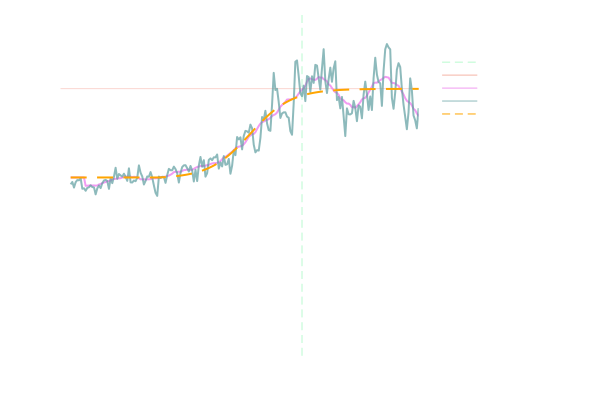

In [4]:
Pm = ICP[infusion_start_frame:infusion_end_frame]
t = 0.0
MODVAL = zeros(length(Pm))

dsampf = 20
numsamples = length(ICP)
gg = moving_average(ICP, dsampf)
g0 = zeros(length(ICP))
g0 .+= P_b
g0[Int(dsampf / 2):Int(dsampf / 2)+length(gg)-1] = gg
g0[Int(dsampf / 2)+length(gg):end] .= P_p

# SET PARAMS FOR OPTIM
# Pm = ICP[infusion_start_frame:infusion_end_frame]
Pm = g0[infusion_start_frame:infusion_end_frame]
lower = [0.0, 0.0, -5.0]
upper = [1.0, 1.0, P_b]
C = 10^3
κ = 2
# x0 = [Ibest, Eest, P0est]
x0 = [0.3, 0.16, 10.0]
alglist = [:LN_NELDERMEAD, :GN_ISRES, :GN_DIRECT, :GN_DIRECT_L, :GN_DIRECT_L_RAND, :GN_CRS2_LM]
# alglist = [:GN_DIRECT_L]

minerrval = 10.0
minerrmet = ""
for optimMethod in alglist
    optalg = optimMethod
    model, I_b, E, P_0 = getModel(optalg, x0)
    errval = objective_value(model)
    if I_b < minerrval && I_b > 0.15
        global minerrval = I_b
        global minmet = optimMethod
    end
    println("Method: $optimMethod\nError value:\n$errval")
    println("Estimated parameters:\nIₐ = $I_b [mL/min]\n" * "E = $E [mmHg/mL]\n" * "P₀ = $P_0 [mmHg]\n")
end
# Pm = g0[infusion_start_frame:infusion_end_frame]
plot_model(I_b, E, P_0, ICP, dsampf)
# minerrval, minmet

In [ ]:
x0

In [ ]:
x0

In [ ]:
err = 0.0
I_b, E, P_0 = [x0...]
for i = 1:length(Pm)
    tᵢ = (i - 1) / 6
    global t = tᵢ
    It = I_b + I_inf
    ΔP = P_b - P_0
    predᵢ = It * ΔP / (I_b + (I_inf * exp(-E * It * tᵢ))) + P_0
    MODVAL[i] = predᵢ
    err += (Pm[i] - predᵢ)^2
end

err

In [ ]:
v = 0:0.001:1.0
sm_v = exp.(v)./sum(exp.(v))
plot(sm_v)